In [1]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import os
import re
import pprint

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
load_dotenv(find_dotenv())

%load_ext autoreload
%autoreload 2
os.getcwd()

'/srv/idp-radio-1'

In [2]:
from src.architectures.benchmarks.benchmark_definitions import Chexpert_Benchmark, Chestxray14_Benchmark, simple_architecture_experiment, generate_benchmarks, METRICS, CHEXPERT_COLUMNS, CHESTXRAY14_COLUMNS


In [3]:
reduced_columns = ['Enlarged Cardiomediastinum',
                    'Cardiomegaly',
                    'Lung Opacity',
                    'Lung Lesion',
                    'Edema',
                    'Consolidation',
                    'Pneumonia',
                    'Atelectasis',
                    'Pneumothorax',
                    'Pleural Effusion',
                    'Pleural Other',
                    'Fracture']
len(reduced_columns)

12

In [37]:
chexpert_benchmarks, _ = generate_benchmarks(path = Path(os.environ.get("CHEXPERT_DATASET_DIRECTORY")),
                                                     name_suffix="",
                                                     classes=reduced_columns,
                                                     test_labels = "test.csv",
                                                     split_valid_size = 0.05,
                                                     # train_labels = "nofinding_train.csv",
                                                     nan_replacement = -1, #float("NaN"),
                                                     batch_sizes = {"b": 32},
                                                     epoch_sizes = {"e": 1},
                                                     dim=(320, 320),
                                                     crop = {"C0": False},
                                                     split_seed = 65748123,
                                                     augmentation=None)

Chestxray_BCE_E1_B32_C0_N12 could not be created
Chestxray_WBCE_E1_B32_C0_N12 could not be created
Chestxray_CWBCE_E1_B32_C0_N12 could not be created


In [38]:
list(chexpert_benchmarks.keys())[0]

'BCE_E1_B32_C0_N12'

In [39]:
benchmark = chexpert_benchmarks[list(chexpert_benchmarks.keys())[0]]

In [40]:
benchmark_dict = benchmark.as_dict()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(benchmark_dict)

{   'augmentation': None,
    'batch_size': 32,
    'benchmark_name': 'Chexpert_BCE_E1_B32_C0_N12',
    'crop': False,
    'dataset_folder': 'data/chexpert/full',
    'dataset_name': 'chexpert_full',
    'dim': (320, 320),
    'drop_last': False,
    'epochs': 1,
    'label_columns': [   'Enlarged Cardiomediastinum',
                         'Cardiomegaly',
                         'Lung Opacity',
                         'Lung Lesion',
                         'Edema',
                         'Consolidation',
                         'Pneumonia',
                         'Atelectasis',
                         'Pneumothorax',
                         'Pleural Effusion',
                         'Pleural Other',
                         'Fracture'],
    'learning_rate': 0.001,
    'loss': 'binary_crossentropy',
    'metrics': [   'auc',
                   'precision',
                   'recall',
                   'f2_score',
                   'binary_accuracy',
                   '

In [41]:
benchmark.label_columns

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture']

In [42]:
train_labels = benchmark.traingen.get_labels()
valid_labels = benchmark.valgen.get_labels()
test_labels = benchmark.testgen.get_labels()

print("Number train samples:", len(train_labels))
print("Number valid samples:", len(valid_labels))
print("Number test samples:", len(test_labels))

Number train samples: 211864
Number valid samples: 11550
Number test samples: 234


In [43]:
def get_distribution(labels):
    labels_df = pd.DataFrame(labels, columns=benchmark.label_columns)


    d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Negative': [], 'Negative %': [],}
    for label in labels_df.columns:
        values = labels_df.groupby(label)
        d['Pathology'].append(label)

        positive = values.size()[1.0] if 1.0 in values.size() else 0
        positive_percent = positive / labels_df.shape[0] * 100
        d['Positive'].append(positive)
        d['Positive %'].append(round(positive_percent, 2))

        negative = values.size()[-0.0] if -0.0 in values.size() else 0
        negative_percent = negative / labels_df.shape[0] * 100
        d['Negative'].append(negative)
        d['Negative %'].append(round(negative_percent, 2))
    
    df = pd.DataFrame(d)
    df = df.set_index('Pathology')

    return df

<AxesSubplot:title={'center':'Test set'}, xlabel='Pathology'>

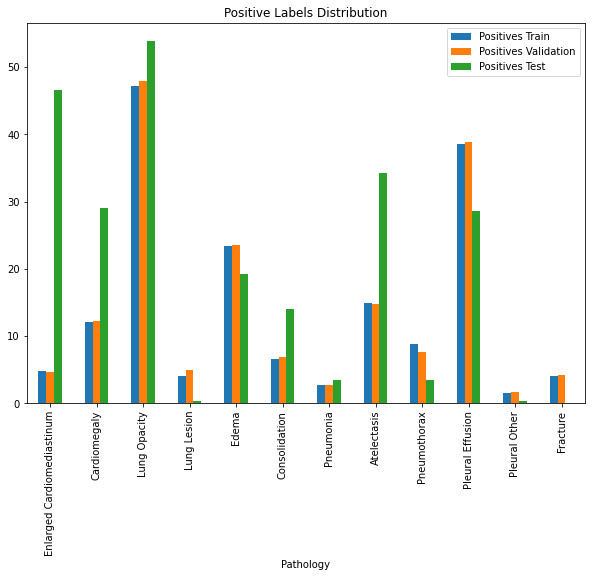

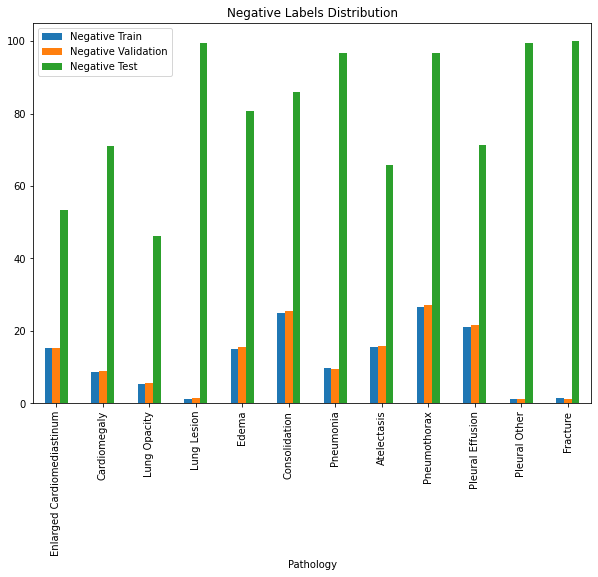

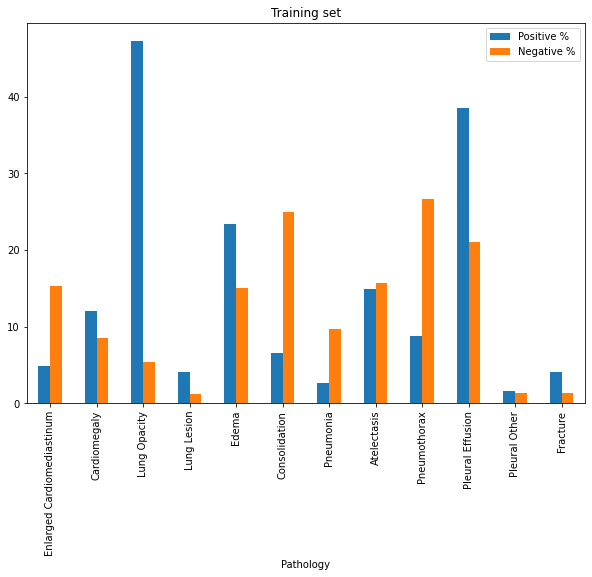

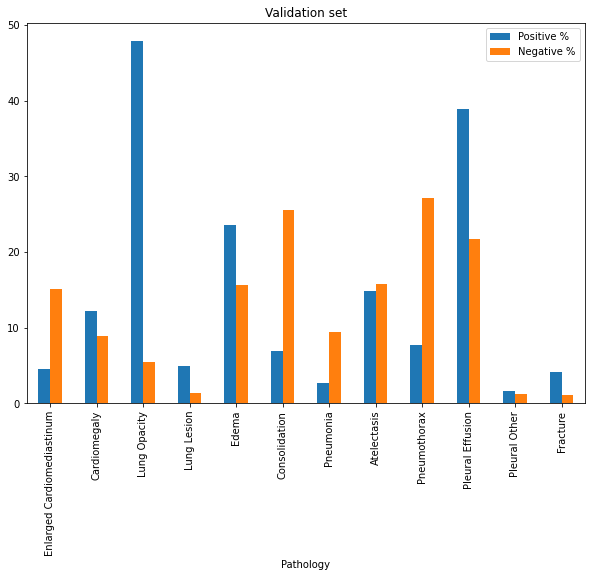

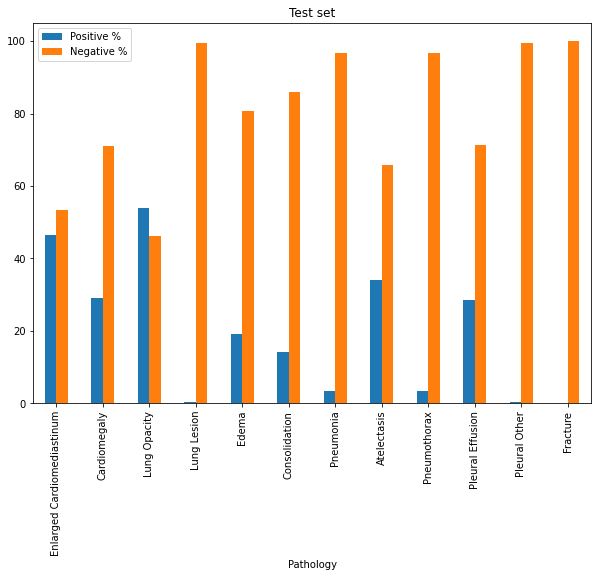

In [44]:
train = get_distribution(train_labels)
val = get_distribution(valid_labels)
test = get_distribution(test_labels)

positives = train[['Positive %']].merge(val[['Positive %']], left_index=True, right_index=True).merge(test[['Positive %']], left_index=True,  right_index=True).rename(columns={"Positive %_x": "Positives Train", "Positive %_y": "Positives Validation", "Positive %": "Positives Test", })
positives.copy().plot(kind='bar', figsize=(10,7), title="Positive Labels Distribution")

negatives = train[['Negative %']].merge(val[['Negative %']], left_index=True, right_index=True).merge(test[['Negative %']], left_index=True,  right_index=True).rename(columns={"Negative %_x": "Negative Train", "Negative %_y": "Negative Validation", "Negative %": "Negative Test", })
negatives.copy().plot(kind='bar', figsize=(10,7), title="Negative Labels Distribution")

train[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")
val[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Validation set")
test[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Test set")

In [45]:
get_distribution(train_labels)

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,10266,4.85,32290,15.24
Cardiomegaly,25589,12.08,18170,8.58
Lung Opacity,100053,47.23,11559,5.46
Lung Lesion,8616,4.07,2598,1.23
Edema,49527,23.38,31898,15.06
Consolidation,13987,6.60,52883,24.96
Pneumonia,5722,2.70,20478,9.67
Atelectasis,31666,14.95,33247,15.69
Pneumothorax,18562,8.76,56348,26.60


In [46]:
get_distribution(valid_labels)

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,532,4.61,1751,15.16
Cardiomegaly,1411,12.22,1033,8.94
Lung Opacity,5528,47.86,638,5.52
Lung Lesion,570,4.94,160,1.39
Edema,2719,23.54,1812,15.69
Consolidation,796,6.89,2956,25.59
Pneumonia,317,2.74,1091,9.45
Atelectasis,1710,14.81,1820,15.76
Pneumothorax,886,7.67,3138,27.17


In [47]:
get_distribution(test_labels)

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,109,46.58,125,53.42
Cardiomegaly,68,29.06,166,70.94
Lung Opacity,126,53.85,108,46.15
Lung Lesion,1,0.43,233,99.57
Edema,45,19.23,189,80.77
Consolidation,33,14.10,201,85.90
Pneumonia,8,3.42,226,96.58
Atelectasis,80,34.19,154,65.81
Pneumothorax,8,3.42,226,96.58


In [64]:
import math
def plot_batch(generator, batchnum):
    batch_size = generator.batch_size
    plot_height = 5 if batch_size > 1 else 60
    plot_width = 5 if batch_size > 1 else 60
    fig_size_x = 4 if batch_size >= 4 else 1
    fig_size_y = math.ceil(batch_size / fig_size_x)
    figsize = (plot_width * fig_size_x, plot_height * fig_size_y)
    plt.figure(figsize=figsize)
    i = 0
    for img in generator[batchnum][0]:
        plt.subplot(8, 4, i+1)
        # Plot the image
        plt.imshow(img)
        plt.axis('off')
        i += 1
    plt.show()

(20, 40)


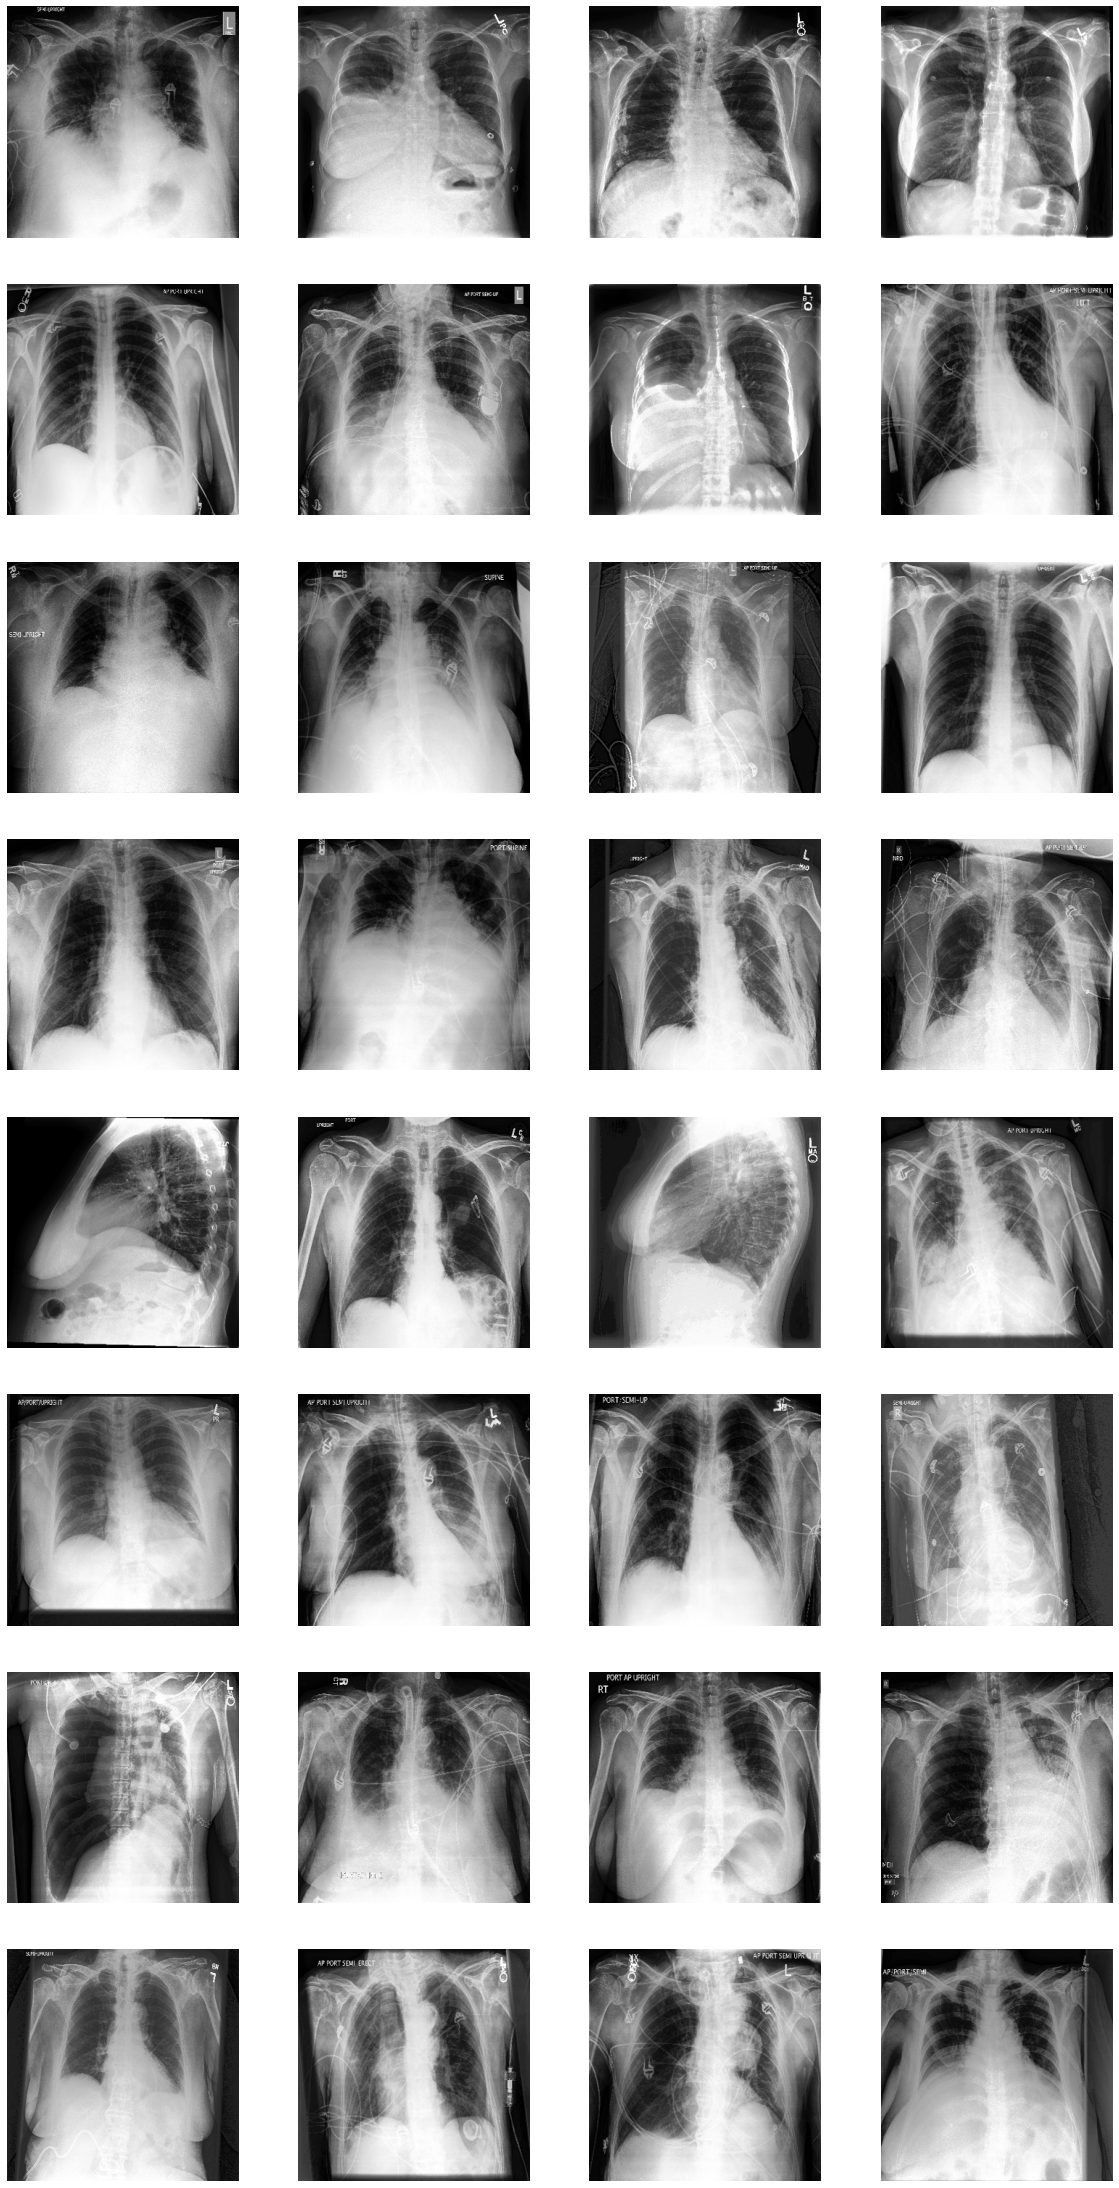

In [69]:
plot_batch(benchmark.valgen, 3)

In [52]:
benchmark.testgen.batch_size

1